In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Bring in hard drive dataset of select columns (whole Backblaze data is too big :/)
df_raw = pd.read_csv('drive_stats_2019_Q1_interested.csv')

In [3]:
# Make copy so I don't have to reimport again
df = df_raw.copy()

In [4]:
# Changes I know I need to make
df = df.drop(columns=['Unnamed: 0',
                    'smart_5_normalized',
                    'smart_9_normalized',
                    'smart_12_normalized',
                    'smart_187_normalized',
                    'smart_188_normalized',
                    'smart_189_normalized',
                    'smart_197_normalized',
                    'smart_198_normalized'])
# Changing some dtypes
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
#df['failure'] = df['failure'].astype('bool')

# Adding couple other columns then moving them
df['capacity_gigabytes'] = df.capacity_bytes // 1000000000
df['capacity_terabytes'] = df.capacity_gigabytes // 1000

def movecol(df, cols_to_move=[], ref_col='', place='After'):
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

df = movecol(df, 
             cols_to_move=['capacity_gigabytes','capacity_terabytes'], 
             ref_col='capacity_bytes',
             place='After')

In [5]:
# Renaming columns
new_columns = {
    'serial_number': 'sn',
    'capacity_bytes': 'cap_b',
    'capacity_gigabytes': 'cap_gb',
    'capacity_terabytes': 'cap_tb',
    'smart_5_raw':'reallocated_sector_count',
    'smart_9_raw':'operational_hours',
    'smart_12_raw':'turned__off_on',
    'smart_187_raw':'uncorrectable_errors',
    'smart_188_raw':'command_timeout',
    'smart_189_raw':'high_fly_writes',
    'smart_197_raw':'pending_sector_count',
    'smart_198_raw':'uncorrectable_sector_count'
}
df.rename(columns=new_columns, inplace=True)

In [6]:
# Check it out
print(df.shape)
df.head()

(9577046, 15)


,date,sn,model,cap_b,cap_gb,cap_tb,failure,reallocated_sector_count,operational_hours,turned__off_on,uncorrectable_errors,command_timeout,high_fly_writes,pending_sector_count,uncorrectable_sector_count
0,2019-01-01,Z305B2QN,ST4000DM000,4000787030016,4000,4,0,0.0,26712.0,12.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01,ZJV0XJQ4,ST12000NM0007,12000138625024,12000,12,0,0.0,3753.0,2.0,0.0,0.0,NaN,0.0,0.0
2,2019-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,12000,12,0,0.0,792.0,1.0,0.0,0.0,NaN,0.0,0.0
3,2019-01-01,ZJV0XJQ0,ST12000NM0007,12000138625024,12000,12,0,0.0,4356.0,6.0,0.0,0.0,NaN,0.0,0.0
4,2019-01-01,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,4000,4,0,0.0,16788.0,8.0,NaN,NaN,NaN,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9577046 entries, 0 to 9577045
Data columns (total 15 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   date                        datetime64[ns]
 1   sn                          object        
 2   model                       object        
 3   cap_b                       int64         
 4   cap_gb                      int64         
 5   cap_tb                      int64         
 6   failure                     int64         
 7   reallocated_sector_count    float64       
 8   operational_hours           float64       
 9   turned__off_on              float64       
 10  uncorrectable_errors        float64       
 11  command_timeout             float64       
 12  high_fly_writes             float64       
 13  pending_sector_count        float64       
 14  uncorrectable_sector_count  float64       
dtypes: datetime64[ns](1), float64(8), int64(4), object(2)
memory usage

#### Dataset Description
Since 2013, [Backblaze](https://www.backblaze.com/) has published statistics and insights based on the hard drives in their data center. They publish the data underlying their reports, so that anyone can reproduce them. A more in depth look into the context, content, and acknowledgments for this dataset can be found [here](https://www.backblaze.com/b2/hard-drive-test-data.html#downloading-the-raw-hard-drive-test-data).

Time to explain everything

#### Variable Descriptions
Format: `variable` (type) - description
- `date` () - The date of the file in yyyy-mm-dd format.
- `sn`  () - The manufacturer-assigned serial number of the drive.
- `model` () - The manufacturer-assigned model number of the drive.
        WD... = Western Digital
        ST... = Seagate
        HD... = Deskstar
        TOSHIBA... = Toshiba
- `cap_b` () - The drive capacity in bytes (1 byte = 8 bits)
- `cap_gb` () = The drive capacity in gigabytes. (1 GB = 1,000,000,000 bytes)
- `cap_tb` () = The drive capacity in terabytes. (1 TB = 1000 GB)
- `failure` () = Contains a “0” if the drive is OK. Contains a “1” if this is the last day the drive was operational before failing.

The following are the Raw and Normalized values for 8 currated SMART stats as reported by the given drive. Each value is the number reported by the drive.

**S.M.A.R.T.** (Self-Monitoring, Analysis, and Reporting Technology) is a monitoring technology supported by most of the modern hard drives. With this technology different internal and external problems of a disk (such as a number of bad blocks, increasing number of errors or start/stop cycles, rising airflow temperature, and so on) may be monitored and reported to the user in good time. Some of the electro-mechanical problems reported by S.M.A.R.T. may lead to an imminent hard drive failure and data loss. Other parameters informs about potential problems with a disk in the future and do not require immediate actions to be taken.

Statistically S.M.A.R.T. can predict more than a half of all hard drive failures, which makes this technology a reliable source of information about current hard disk state. But anyway, such monitoring does not substitute the necessity of keeping up-to-date backups for your data. Such backup archives will protect you from crucial data loss in case of logical corruption, physical damaging, destroying or even loosing the hardware, which cannot be predicted by any kind of monitoring.

S.M.A.R.T. parameters describe specific aspects of the hard disk state – surface damages, read/write errors, problems with electro-mechanical components, etc. When a value of a parameter considered critical decreases, a disk failure probability raises up to 30 times. This means a crash may happen in a near future and you need an urgent hardware replacement to avoid crucial data loss.

Each hardware manufacturer supports its own set of S.M.A.R.T. parameters, which may also differ from one disk model to another.

The ones that interest me are as follows:

- `smart_5` () - **Reallocated Sector Count** - SMART parameter indicates the count of reallocated sectors (512 bytes). When the hard drive finds a read/write/verification error, it marks this sector as "reallocated" and transfers data to a special reserved area (spare area). This process is also known as remapping and "reallocated" sectors are called remaps. This is why, on a modern hard disks, you will not see "bad blocks" while testing the surface - all bad blocks are hidden in reallocated sectors.

However, the more sectors that are reallocated, the more a sudden decrease (up to 10% and more) can be noticed in the disk read/write speed.

- `smart_9` () - **Power-On Hours (POH)** - SMART parameter indicates a count of hours in power-on state. The value of this attribute shows total count of hours (or minutes, or seconds, depending on manufacturer) in power-on state. A decrease of this attribute value to the critical level (threshold) indicates a decrease of the MTBF (Mean Time Between Failures).
- `smart_12` () - **Power Cycle Count** - SMART parameter is an informational parameter and indicates the count of full hard disk power on/off cycles.
- `smart187` () - **Reported Uncorrectable Errors** - SMART parameter indicates a number of errors that could not be recovered using hardware ECC (error-correcting code).
- `smart188` () - **Command Timeout** - SMART parameter indicates a number of aborted operations due to hard disk timeout.
- `smart189` () - **High Fly Writes** - SMART parameter indicates the count of these errors detected over the lifetime of the drive. HDD producers implement a Fly Height Monitor that attempts to provide additional protections for write operations by detecting when a recording head is flying outside its normal operating range. If an unsafe fly height condition is encountered, the write process is stopped, and the information is rewritten or reallocated to a safe region of the hard drive.
- `smart_197` () - **Current Pending Sector Count** - SMART parameter is a critical parameter and indicates the current count of unstable sectors (waiting for remapping). The raw value of this attribute indicates the total number of sectors waiting for remapping. Later, when some of these sectors are read successfully, the value is decreased. If errors still occur when reading some sector, the hard drive will try to restore the data, transfer it to the reserved disk area (spare area) and mark this sector as remapped.
- `smart_198` () - **Uncorrectable Sector Count** - SMART parameter is a critical parameter and indicates the quantity of uncorrectable errors. The raw value of this attribute indicates the total number of uncorrectable errors when reading/writing a sector.

In [8]:
# Descriptive Statistics Summary
df.describe()

,cap_b,cap_gb,cap_tb,failure,reallocated_sector_count,operational_hours,turned__off_on,uncorrectable_errors,command_timeout,high_fly_writes,pending_sector_count,uncorrectable_sector_count
count,9.577046e+06,9.577046e+06,9.577046e+06,9.577046e+06,9.573683e+06,9.575512e+06,9.575512e+06,7.394928e+06,7.394928e+06,4.440134e+06,9.573683e+06,9.573683e+06
mean,7.804059e+12,7.803569e+03,7.794074e+00,4.636085e-05,7.513229e+00,1.711924e+04,5.764923e+00,6.992928e-02,1.199410e+08,6.557257e+00,9.589852e-02,9.126352e-02
std,3.573331e+12,3.573565e+03,3.593048e+00,6.808723e-03,3.714430e+02,1.028049e+04,1.242143e+01,3.538318e+00,3.604996e+09,5.128213e+02,4.779867e+00,4.769852e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000787e+12,4.000000e+03,4.000000e+00,0.000000e+00,0.000000e+00,9.589000e+03,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.001563e+12,8.001000e+03,8.000000e+00,0.000000e+00,0.000000e+00,1.578200e+04,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.200014e+13,1.200000e+04,1.200000e+01,0.000000e+00,0.000000e+00,2.541800e+04,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.400052e+13,1.400000e+04,1.400000e+01,1.000000e+00,6.528800e+04,7.077000e+04,1.232000e+03,2.165000e+03,6.013057e+11,6.553500e+04,6.536000e+03,6.536000e+03


In [9]:
df.describe(include=['O'])

,sn,model
count,9577046,9577046
unique,115231,49
top,ZA18CDBS,ST12000NM0007
freq,90,2955025


### Missing Values

In [10]:
# Percentage of each column that is null
df.isnull().sum()*100/df.isnull().count()

date                           0.000000
sn                             0.000000
model                          0.000000
cap_b                          0.000000
cap_gb                         0.000000
cap_tb                         0.000000
failure                        0.000000
reallocated_sector_count       0.035115
operational_hours              0.016017
turned__off_on                 0.016017
uncorrectable_errors          22.784875
command_timeout               22.784875
high_fly_writes               53.637750
pending_sector_count           0.035115
uncorrectable_sector_count     0.035115
dtype: float64

In [11]:
list(df.columns)

['date',
 'sn',
 'model',
 'cap_b',
 'cap_gb',
 'cap_tb',
 'failure',
 'reallocated_sector_count',
 'operational_hours',
 'turned__off_on',
 'uncorrectable_errors',
 'command_timeout',
 'high_fly_writes',
 'pending_sector_count',
 'uncorrectable_sector_count']

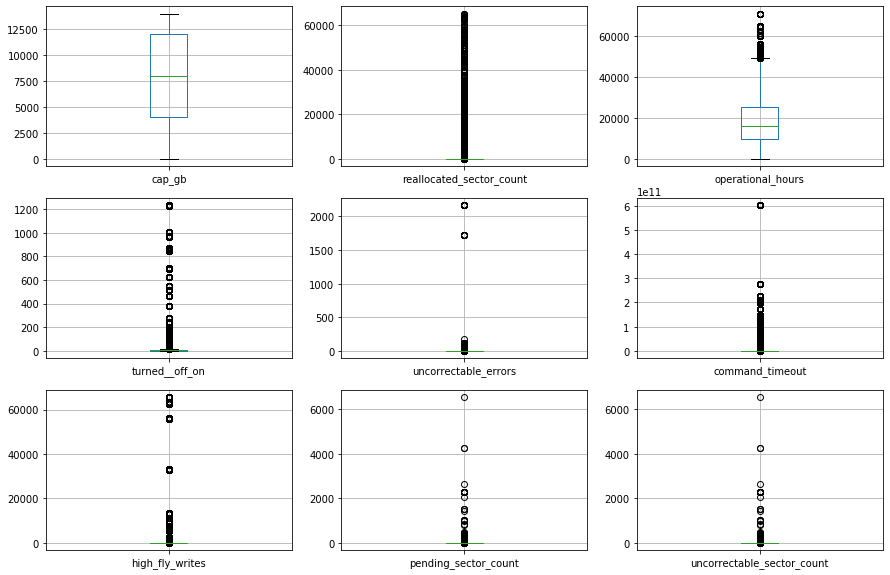

In [12]:
columns_of_interest = ['cap_gb', 
                       'reallocated_sector_count', 
                       'operational_hours', 
                       'turned__off_on', 
                       'uncorrectable_errors', 
                       'command_timeout', 
                       'high_fly_writes', 
                       'pending_sector_count', 
                       'uncorrectable_sector_count'
]
plt.figure(figsize=(15,10))

for i, col in enumerate(columns_of_interest, start=1):
    plt.subplot(3, 3, i)
    df.boxplot(col)

In [13]:
def nulls_breakdown(df=df):
    df_cols = list(df.columns)
    cols_total_count = len(list(df.columns))
    cols_count = 0
    for loc, col in enumerate(df_cols):
        null_count = df[col].isnull().sum()
        total_count = df[col].isnull().count()
        percent_null = round(null_count/total_count*100, 2)
        if null_count > 0:
            cols_count += 1
            print('[iloc = {}] {} has {} null values: {}% null'.format(
                loc, col, null_count, percent_null))
    cols_percent_null = round(cols_count/cols_total_count*100, 2)
    print('')
    print('Out of {} total columns, {} contain null values; {}% columns contain null values.'.format(
        cols_total_count, cols_count, cols_percent_null))

In [14]:
nulls_breakdown()

[iloc = 7] reallocated_sector_count has 3363 null values: 0.04% null
[iloc = 8] operational_hours has 1534 null values: 0.02% null
[iloc = 9] turned__off_on has 1534 null values: 0.02% null
[iloc = 10] uncorrectable_errors has 2182118 null values: 22.78% null
[iloc = 11] command_timeout has 2182118 null values: 22.78% null
[iloc = 12] high_fly_writes has 5136912 null values: 53.64% null
[iloc = 13] pending_sector_count has 3363 null values: 0.04% null
[iloc = 14] uncorrectable_sector_count has 3363 null values: 0.04% null

Out of 15 total columns, 8 contain null values; 53.33% columns contain null values.


In [15]:
# Look into failure distributions
df['failure'].value_counts()

0    9576602
1        444
Name: failure, dtype: int64

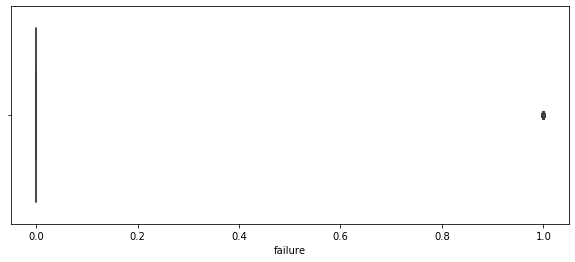

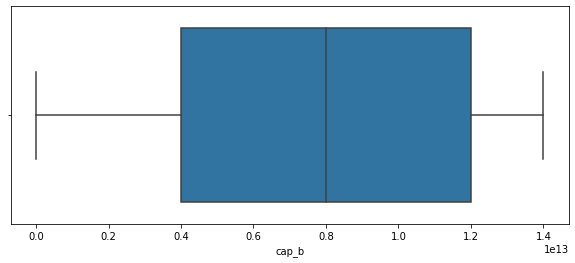

In [16]:
# Bot Plot of capacity_bytes and failure

plt.figure(figsize=(10,4))
sns.boxplot(x=df.failure)

plt.figure(figsize=(10,4))
sns.boxplot(x=df.cap_b)

In [17]:
# Obtain the failed hard drive disks into dataframe
hd_fail_data = df[df.failure == 1]
hd_fail_data.head()

,date,sn,model,cap_b,cap_gb,cap_tb,failure,reallocated_sector_count,operational_hours,turned__off_on,uncorrectable_errors,command_timeout,high_fly_writes,pending_sector_count,uncorrectable_sector_count
17321,2019-01-01,ZA18197Z,ST8000NM0055,8001563222016,8001,8,1,29616.0,12419.0,5.0,112.0,0.000000e+00,0.0,0.0,0.0
67885,2019-01-01,S300YTAY,ST4000DM000,4000787030016,4000,4,1,760.0,31801.0,13.0,0.0,0.000000e+00,0.0,0.0,0.0
71537,2019-01-01,S300ZREZ,ST4000DM000,4000787030016,4000,4,1,40.0,30678.0,8.0,51.0,0.000000e+00,0.0,24.0,24.0
103805,2019-01-01,ZA180YM3,ST8000NM0055,8001563222016,8001,8,1,0.0,12921.0,6.0,0.0,0.000000e+00,0.0,0.0,0.0
113120,2019-01-02,ZDEB35E7,ST500LM030,500107862016,500,0,1,0.0,3204.0,3.0,0.0,8.590066e+09,0.0,0.0,0.0


In [18]:
hd_fail_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444 entries, 17321 to 9391185
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        444 non-null    datetime64[ns]
 1   sn                          444 non-null    object        
 2   model                       444 non-null    object        
 3   cap_b                       444 non-null    int64         
 4   cap_gb                      444 non-null    int64         
 5   cap_tb                      444 non-null    int64         
 6   failure                     444 non-null    int64         
 7   reallocated_sector_count    443 non-null    float64       
 8   operational_hours           443 non-null    float64       
 9   turned__off_on              443 non-null    float64       
 10  uncorrectable_errors        387 non-null    float64       
 11  command_timeout             387 non-null    float6

In [19]:
hd_fail_data.notnull().count(axis=0)

date                          444
sn                            444
model                         444
cap_b                         444
cap_gb                        444
cap_tb                        444
failure                       444
reallocated_sector_count      444
operational_hours             444
turned__off_on                444
uncorrectable_errors          444
command_timeout               444
high_fly_writes               444
pending_sector_count          444
uncorrectable_sector_count    444
dtype: int64

In [25]:
#df_inter = df.groupby(['sn'], sort=False).apply(
#    lambda group: group.interpolate(method='linear', limit_direction='both'))

# df_inter.to_csv('drive_stats_2019_Q1_interpolated.csv')

df_inter = pd.read_csv('drive_stats_2019_Q1_interpolated.csv').drop(columns=['Unnamed: 0'])

In [26]:
nulls_breakdown(df)

[iloc = 7] reallocated_sector_count has 3363 null values: 0.04% null
[iloc = 8] operational_hours has 1534 null values: 0.02% null
[iloc = 9] turned__off_on has 1534 null values: 0.02% null
[iloc = 10] uncorrectable_errors has 2182118 null values: 22.78% null
[iloc = 11] command_timeout has 2182118 null values: 22.78% null
[iloc = 12] high_fly_writes has 5136912 null values: 53.64% null
[iloc = 13] pending_sector_count has 3363 null values: 0.04% null
[iloc = 14] uncorrectable_sector_count has 3363 null values: 0.04% null

Out of 15 total columns, 8 contain null values; 53.33% columns contain null values.


In [27]:
nulls_breakdown(df_inter)

[iloc = 7] reallocated_sector_count has 2369 null values: 0.02% null
[iloc = 8] operational_hours has 540 null values: 0.01% null
[iloc = 9] turned__off_on has 540 null values: 0.01% null
[iloc = 10] uncorrectable_errors has 2181647 null values: 22.78% null
[iloc = 11] command_timeout has 2181647 null values: 22.78% null
[iloc = 12] high_fly_writes has 5136672 null values: 53.64% null
[iloc = 13] pending_sector_count has 2369 null values: 0.02% null
[iloc = 14] uncorrectable_sector_count has 2369 null values: 0.02% null

Out of 15 total columns, 8 contain null values; 53.33% columns contain null values.


In [110]:
hd_fail_data_full = pd.DataFrame() #creates a new dataframe that's empty

for i in range(hd_fail_data.shape[0]):
    serial = hd_fail_data.sn.iloc[i]
    hd_fail_data_full = hd_fail_data_full.append(df.loc[df.sn == serial], ignore_index = True)

In [29]:
from menning import menning_ds as menning

In [30]:
menning.show_max_rows(hd_fail_data)

,date,sn,model,cap_b,cap_gb,cap_tb,failure,reallocated_sector_count,operational_hours,turned__off_on,uncorrectable_errors,command_timeout,high_fly_writes,pending_sector_count,uncorrectable_sector_count
17321,2019-01-01,ZA18197Z,ST8000NM0055,8001563222016,8001,8,1,29616.0,12419.0,5.0,112.0,0.000000e+00,0.0,0.0,0.0
67885,2019-01-01,S300YTAY,ST4000DM000,4000787030016,4000,4,1,760.0,31801.0,13.0,0.0,0.000000e+00,0.0,0.0,0.0
71537,2019-01-01,S300ZREZ,ST4000DM000,4000787030016,4000,4,1,40.0,30678.0,8.0,51.0,0.000000e+00,0.0,24.0,24.0
103805,2019-01-01,ZA180YM3,ST8000NM0055,8001563222016,8001,8,1,0.0,12921.0,6.0,0.0,0.000000e+00,0.0,0.0,0.0
113120,2019-01-02,ZDEB35E7,ST500LM030,500107862016,500,0,1,0.0,3204.0,3.0,0.0,8.590066e+09,0.0,0.0,0.0
120546,2019-01-02,ZCH07RLC,ST12000NM0007,12000138625024,12000,12,1,304.0,10512.0,2.0,0.0,0.000000e+00,NaN,0.0,0.0
142484,2019-01-02,ZA120GQQ,ST8000DM002,8001563222016,8001,8,1,5224.0,22207.0,4.0,22.0,0.000000e+00,0.0,0.0,0.0
182106,2019-01-02,Z302T6AB,ST4000DM000,4000787030016,4000,4,1,32.0,29239.0,4.0,38.0,0.000000e+00,0.0,424.0,424.0
186223,2019-01-02,Z3026Q5Y,ST4000DM000,4000787030016,4000,4,1,0.0,29455.0,14.0,4.0,0.000000e+00,0.0,32.0,32.0
216648,2019-01-03,W300THEG,ST4000DM000,4000787030016,4000,4,1,920.0,31926.0,1.0,14.0,0.000000e+00,0.0,8.0,8.0


In [102]:
def show_max_rows(df):
    pd.set_option('display.max_rows', len(df))
    display(df)
    pd.reset_option('display.max_rows')

def show_max_columns(df):
    pd.set_option('display.max_columns', df.shape[1])
    display(df)
    pd.reset_option('display.max_columns')
    
def show_full(df):
    pd.set_option('display.max_rows', len(df))
    pd.set_option('display.max_columns', df.shape[1])
    display(df)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

In [111]:
hd_fail_data_full.shape

(19778, 15)

In [112]:
#show_max_rows(hd_fail_data_full[-100:])

,date,sn,model,cap_b,cap_gb,cap_tb,failure,reallocated_sector_count,operational_hours,turned__off_on,uncorrectable_errors,command_timeout,high_fly_writes,pending_sector_count,uncorrectable_sector_count
19678,2019-03-19,ZA17G86N,ST8000NM0055,8001563222016,8001,8,0,378.0,13608.0,3.0,3.0,0.0,0.0,64.0,64.0
19679,2019-03-20,ZA17G86N,ST8000NM0055,8001563222016,8001,8,0,378.0,13624.0,3.0,3.0,0.0,0.0,64.0,64.0
19680,2019-03-21,ZA17G86N,ST8000NM0055,8001563222016,8001,8,0,394.0,13656.0,3.0,3.0,0.0,0.0,64.0,64.0
19681,2019-03-22,ZA17G86N,ST8000NM0055,8001563222016,8001,8,0,394.0,13687.0,3.0,3.0,0.0,0.0,64.0,64.0
19682,2019-03-23,ZA17G86N,ST8000NM0055,8001563222016,8001,8,0,394.0,13703.0,3.0,3.0,0.0,0.0,64.0,64.0
19683,2019-03-24,ZA17G86N,ST8000NM0055,8001563222016,8001,8,0,394.0,13735.0,3.0,3.0,0.0,0.0,64.0,64.0
19684,2019-03-25,ZA17G86N,ST8000NM0055,8001563222016,8001,8,0,394.0,13750.0,3.0,3.0,0.0,0.0,64.0,64.0
19685,2019-03-26,ZA17G86N,ST8000NM0055,8001563222016,8001,8,0,394.0,13782.0,3.0,3.0,0.0,0.0,64.0,64.0
19686,2019-03-27,ZA17G86N,ST8000NM0055,8001563222016,8001,8,0,418.0,13798.0,3.0,3.0,0.0,0.0,64.0,64.0
19687,2019-03-28,ZA17G86N,ST8000NM0055,8001563222016,8001,8,0,418.0,13829.0,3.0,3.0,0.0,0.0,64.0,64.0


In [25]:
# Find the lifetime of failed hard drives
# smart9 contains info on how many hours the drive was operational
# dividing by 24 will give number of days
    
hd_fail_data['lifetime'] = hd_fail_data.smart_9_raw // 24
hd_fail_data.head()

C:\Users\Kenei\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,date,sn,model,cap_b,cap_gb,cap_tb,failure,smart_5_norm,smart_5_raw,smart_9_norm,...,smart_187_raw,smart_188_norm,smart_188_raw,smart_189_norm,smart_189_raw,smart_197_norm,smart_197_raw,smart_198_norm,smart_198_raw,lifetime
17321,2019-01-01,ZA18197Z,ST8000NM0055,8001563222016,8001,8,True,93.0,29616.0,86.0,...,112.0,100.0,0.000000e+00,100.0,0.0,100.0,0.0,100.0,0.0,517.0
67885,2019-01-01,S300YTAY,ST4000DM000,4000787030016,4000,4,True,99.0,760.0,64.0,...,0.0,100.0,0.000000e+00,100.0,0.0,100.0,0.0,100.0,0.0,1325.0
71537,2019-01-01,S300ZREZ,ST4000DM000,4000787030016,4000,4,True,100.0,40.0,65.0,...,51.0,100.0,0.000000e+00,100.0,0.0,100.0,24.0,100.0,24.0,1278.0
103805,2019-01-01,ZA180YM3,ST8000NM0055,8001563222016,8001,8,True,100.0,0.0,86.0,...,0.0,100.0,0.000000e+00,100.0,0.0,100.0,0.0,100.0,0.0,538.0
113120,2019-01-02,ZDEB35E7,ST500LM030,500107862016,500,0,True,100.0,0.0,97.0,...,0.0,100.0,8.590066e+09,100.0,0.0,100.0,0.0,100.0,0.0,133.0


In [26]:
filtered_hd_fail_data = hd_fail_data[hd_fail_data.lifetime > 0]
filtered_hd_fail_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 443 entries, 17321 to 9391185
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            443 non-null    datetime64[ns]
 1   sn              443 non-null    object        
 2   model           443 non-null    object        
 3   cap_b           443 non-null    int64         
 4   cap_gb          443 non-null    int64         
 5   cap_tb          443 non-null    int64         
 6   failure         443 non-null    bool          
 7   smart_5_norm    443 non-null    float64       
 8   smart_5_raw     443 non-null    float64       
 9   smart_9_norm    443 non-null    float64       
 10  smart_9_raw     443 non-null    float64       
 11  smart_12_norm   443 non-null    float64       
 12  smart_12_raw    443 non-null    float64       
 13  smart_187_norm  387 non-null    float64       
 14  smart_187_raw   387 non-null    float64       
 15

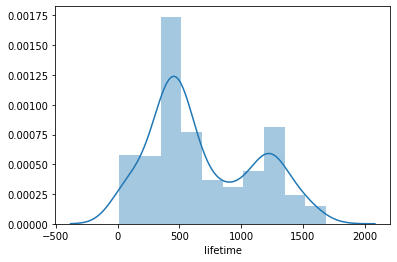

In [27]:
# Distribution of the lifetime
sns.distplot(filtered_hd_fail_data.lifetime);

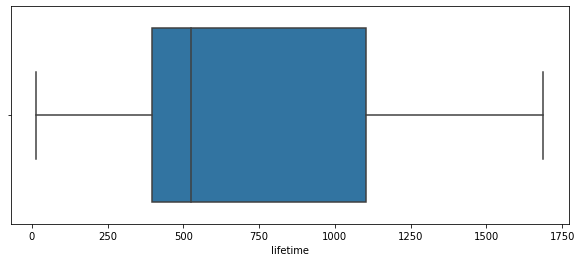

In [28]:
# Box Plot of the lifetime
plt.figure(figsize=(10,4))
sns.boxplot(x=filtered_hd_fail_data.lifetime)